In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

## Parameters and boundary conditions

In [22]:
## Reaction parameters (Gupta 2006)
# First reaction:  CO2   + OH- --> HCO3-
# Second reaction: HCO3- + OH- --> CO3-- + H2O
# Equilibrium constants
H  = 3.4e-4            # [Pa/(m^3 mol)], Henry's law constant
K1 = 4.44e7 * 1e-3     # [m^3/mol] 
K2 = 4.66e3 * 1e-3     # [m^3/mol] 
# Rate constants
k1f    = 5.93e3 * 1e-3 # [m^3/(mol s)]
k1r    = 1.34e-4       # [1/s] 
k2f    = 1.00e8 * 1e-3 # [m^3/(mol s)]
k2r    = 2.15e4        # [1/s]

## Bulk concentrations
# todo: add bulk concentration calculation for co2 using henry's law
PCO2 = 1.01325e5 # partial pressure in Pa
CO2_bulk  = H*PCO2 # bulk concentration [mol/m^3], placeholder value
OH_bulk   = 1/np.sqrt(K1*K2)
HCO3_bulk = H*np.sqrt(K1/K2)*PCO2
CO3_bulk  = H*PCO2

# Values from Joe Lager's GitHub with 500 mM buffer to test
# CO2_bulk  = 33.4 
# OH_bulk   = 10**(-(14-7.526)) * 1e3
# HCO3_bulk = 498.44 
# CO3_bulk  = 0.7807 

print('Bulk solution')
print('CO2:\t', CO2_bulk)
print('OH-:\t', OH_bulk)
print('HCO3-:\t', HCO3_bulk) 
print('CO3--:\t', CO3_bulk)
print('pOH:\t', -np.log10(OH_bulk*1e-3))
print('pH:\t', 14 + np.log10(OH_bulk*1e-3))

## Species parameters (Gupta 2006)
DCO2     = 1.91e-9  # [m^2/s]
DOH      = 5.27e-9  # [m^2/s]
DHCO3    = 1.19e-9  # [m^2/s]
DCO3     = 9.23e-10 # [m^2/s]

## System parameters
L = 100e-6      # diffusion layer length [m]
j = 5 * 1e-6 * 1e4      # electrode current density (default 5 mA/cm^2 = 50 A/m^2) [A/m^2]
F = 96485.33212 # Faraday constant [C/mol]
Npts = 100      # number of points on axis
d = 2*4           # dimension of the solution array, 2*number of species

## Boundary conditions
bc0_CO2  = j/(2*DCO2*F)  # let CO2 flux depend on current density at electrode
bcL_CO2  = CO2_bulk      # bulk concentration at the end of the diffusion layer
bc0_HCO3 = 0             # HCO3- does not react at the electrode
bcL_HCO3 = HCO3_bulk 
bc0_CO3  = 0             # CO3-- does not react at the electrode
bcL_CO3  = CO3_bulk   
bc0_OH   = -j/(DOH*F)    # from reaction with CO2 at the electrode
bcL_OH   = OH_bulk

Bulk solution
CO2:	 34.450500000000005
OH-:	 0.0021984447547293766
HCO3-:	 3362.745933412514
CO3--:	 34.450500000000005
pOH:	 5.65788444340231
pH:	 8.34211555659769


## Solving the differential equations

In [23]:
def odes(x, y):
    """ 
    Define the right-hand side of a system of n first-order ODE's. 
    Arguments: 
    x: coordinate axis (mesh) with shape (m,)
    y: function values along the axis for each component of y. Shape (n,m)
    Returns:
    dydx: array with shape (n,m) containing the derivative for each component 
    of y at each x-position
    """ 
    dydx = np.zeros(y.shape)
    dydx[0,:] = y[1] 
    dydx[1,:] = -1/DCO2 * (-k1f*y[0]*y[6] + k1r*y[2])
    dydx[2,:] = y[3]
    dydx[3,:] = -1/DHCO3 * (k1f*y[0]*y[6] - k1r*y[2] - k2f*y[2]*y[6] + k2r*y[4])
    dydx[4,:] = y[5]
    dydx[5,:] = -1/DCO3 * (k2f*y[2]*y[6] - k2r*y[4])
    dydx[6,:] = y[7]
    dydx[7,:] = -1/DOH * (-k1f*y[0]*y[6] + k1r*y[2] - k2f*y[2]*y[6] + k2r*y[4])
    return dydx 

def bcs(y0, yL):
    """
    Define the residuals of the boundary conditions -- the solver tries to make
    these zero. For n first-order ODE's there should be n boundary conditions.
    Arguments:
    y0: function value at x=0, shape (n,)
    yL: function value at x=L, shape (n,)
    Returns:
    residual: array with residuals to be minimized, shape (n,). The order of 
    these does not really matter. Each element is a function of y0 and yL. 
    For example, if the value of the third element (index 2) of y should be A 
    at x=0, the residual is y0[2] - A.
    """
    residual = np.zeros(y0.shape)
    residual[0] = yL[0] - bcL_CO2 # residual for the BC for y0
    residual[1] = y0[1] - bc0_CO2 
    residual[2] = yL[2] - bcL_HCO3
    residual[3] = y0[3] - bc0_HCO3
    residual[4] = yL[4] - bcL_CO3
    residual[5] = y0[5] - bc0_CO3
    residual[6] = yL[6] - bcL_OH
    residual[7] = y0[7] - bc0_OH
    return residual

x = np.linspace(0, L, Npts)

y_guess = np.zeros((d, Npts))
y_guess[0,:] = CO2_bulk
y_guess[1,:] = CO2_bulk/L
y_guess[2,:] = HCO3_bulk
y_guess[3,:] = HCO3_bulk/L
y_guess[4,:] = CO3_bulk
y_guess[5,:] = -CO3_bulk/L
y_guess[6,:] = OH_bulk
y_guess[7,:] = -OH_bulk/L

odesol = solve_bvp(odes, bcs, x, y_guess, verbose = 2)

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          2.65e+01       0.00e+00          100            198      
       2          2.19e+01       0.00e+00          298            594      
       3          2.27e+01       6.96e-27          892           (641)     
Number of nodes is exceeded after iteration 3. 
Maximum relative residual: 2.27e+01 
Maximum boundary residual: 6.96e-27


## Plotting the results

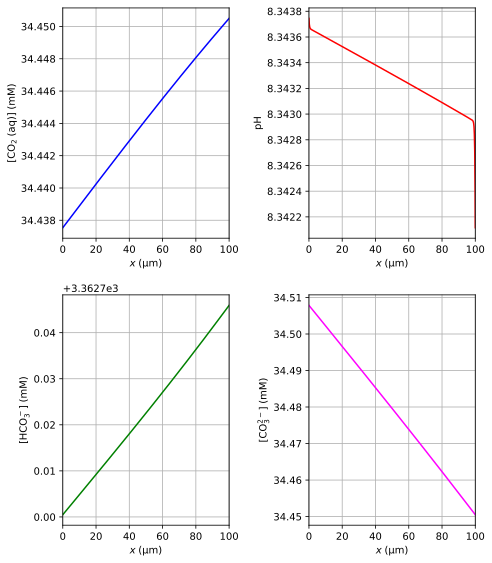

In [24]:
xsol = odesol.x
co2sol = odesol.y[0,:]
hco3sol = odesol.y[2,:]
co3sol = odesol.y[4,:]
ohsol = odesol.y[6,:]
pHsol = 14 + np.log10(ohsol*1e-3)

plt.figure(figsize=(7,8))

plt.subplot(2,2,1)
plt.plot(xsol*1e6, co2sol, 'b')
plt.grid(True)
plt.xlim([0, L*1e6])
plt.xlabel(r'$x \; \mathrm{(\mu m)}$')
plt.ylabel(r'$\mathrm{[CO_2 \; (aq)]} \; \mathrm{(mM)}$')

plt.subplot(2,2,2)
plt.plot(xsol*1e6, pHsol, 'r')
plt.grid(True)
plt.xlim([0, L*1e6])
plt.xlabel(r'$x \; \mathrm{(\mu m)}$')
plt.ylabel(r'$\mathrm{pH}$')

plt.subplot(2,2,3)
plt.plot(xsol*1e6, hco3sol, 'g')
plt.grid(True)
plt.xlim([0, L*1e6])
plt.xlabel(r'$x \; \mathrm{(\mu m)}$')
plt.ylabel(r'$\mathrm{[HCO_3^-]} \; \mathrm{(mM)}$')

plt.subplot(2,2,4)
plt.plot(xsol*1e6, co3sol, 'magenta')
plt.grid(True)
plt.xlim([0, L*1e6])
plt.xlabel(r'$x \; \mathrm{(\mu m)}$')
plt.ylabel(r'$\mathrm{[CO_3^{2-}]} \; \mathrm{(mM)}$')

plt.tight_layout()
plt.show()

## Save data

In [25]:
# Save x-position in micrometers, along with the concentrations and the pH profile
savedata = np.stack([xsol*1e6, co2sol, hco3sol, co3sol, pHsol], axis=-1)
print("Saved data shape:", savedata.shape)

# Save the file with the current density in A/cm^2 in the name
filename = "concentrationdata_{0:.0e}".format(j*1e-4)
print("Filename: ", filename + '.npz')

np.save(filename, savedata)

Saved data shape: (892, 5)
Filename:  concentrationdata_5e-06.npz
